# 1. Data Exploration

## Overview 
In the first section we will look at techniques to load and explore the data to be used for machine learning. The purpose of this exploration to gain an understanding of the data and how it relates to the problem we are trying to solve. This will help us make sensible choices for differents elements of our machine learning pipeline.

### Prerequisities 

To be able to sucessfully work through this notebook, you will need some understanding of the following 
* The python programming language
* Simple data handling in python
* Basic plotting using matplotlib
* Environment set up using pip or conda

### Learning Outcomes 

* Loading tabular and gridded datasets using common python libraries
* typical techniques for *exploratory data analysis* on different
* key characteristics of datasets to use in choosing components for a machine learning pipeline


## Tutorial - Exploratory Data Analysis

The first step in a machine learning problem is to understand the data you have available for training a machine learning algorithm. In any data driven technique, the quality of the results is only going to be as good as the quality of the data. This can only be achieved by matching the appropriate techniques to the data that you have, so understanding the particular dataset to be used is the foundation of a successful outcome.

To achieve this, one typically performs an *Exploratory Data Analysis*, where one produce a series of summary statistics and plots that highlight the most salient characteristics of the dataset for the problem at hand. Typical traits to be considered include:
* The range of values different input feature can take e.g. min and max temperature, start and end dates.
* Important subsets of the data e.g. different seasons or time of the day.
* Distributions of different features, both as a whole and important subsets
* Correlations between different features, especially input and target features.







### Best Practices & Values

Performing a through data exploration implements the Met Office Machine Learning best practices in the following ways
* Ethics - Ensure we can justify our choices from understanding of the data and how it relates to the potential impacts of this work.
* Data - Ensure that we understand biases or other issues with the data
* ML Pitfall -  Avoid pitfalls through making informed choices based on analysis of data
* ML Lifecycle - Ensure we store and proces the data so we can reproduce the results

## Excercise 1: Load and explore tabular dataset - Falkland Islands Airfield Rotors

The first dataset we will explore comes from a challenge by Operational Meteorologist Steve Ramsdale, around forecasting  localised topographically-driven turbulent wind gusts at the Mount Pleasant Airfield in the Falkland Islands, which occur in northerly winds interacting with mountains to the north of the airfield. The aim is to predict whether or not these will occur, using data from global, coarse-resolution models which are not able to to explcitly resolve this phemomenon. 

The target is a human-created dataset produced by Operational Meterologists at the airfield, as to whether a rotor occured in any given three hour period.

In [1]:
import pathlib
import datetime
import os
import functools

In [2]:
import matplotlib
%matplotlib inline

In [3]:
import pandas

In [4]:
import iris
import iris.quickplot
import iris.coord_categorisation
import cartopy


In [5]:
import sklearn
import sklearn.metrics

In [6]:
try:
    falklands_data_dir = os.environ['OPMET_ROTORS_DATA_ROOT']
except KeyError:
    falklands_data_dir = '/project/informatics_lab/data_science_cop/ML_challenges/2021_opmet_challenge'
falklands_data_dir = pathlib.Path(falklands_data_dir) /  'Rotors'
print(falklands_data_dir)

/project/informatics_lab/data_science_cop/ML_challenges/2021_opmet_challenge/Rotors


In [7]:
falklands_data_fname = 'new_training.csv'

In [8]:
falklands_data_path = falklands_data_dir / falklands_data_fname
falklands_data_path

PosixPath('/project/informatics_lab/data_science_cop/ML_challenges/2021_opmet_challenge/Rotors/new_training.csv')

In [9]:
falklands_data_path.is_file()

True

In [10]:
falklands_df = pandas.read_csv(falklands_data_path)

In [11]:
falklands_df

,DTG,air_temp_obs,dewpoint_obs,wind_direction_obs,wind_speed_obs,wind_gust_obs,air_temp_1,air_temp_2,air_temp_3,air_temp_4,...,windspd_18,winddir_19,windspd_19,winddir_20,windspd_20,winddir_21,windspd_21,winddir_22,windspd_22,Rotors 1 is true
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01/01/2015 00:00,283.9,280.7,110.0,4.1,-9999999.0,284.000,283.625,283.250,282.625,...,5.8,341.0,6.0,334.0,6.1,330.0,6.0,329.0,5.8,NaN
2,01/01/2015 03:00,280.7,279.7,90.0,7.7,-9999999.0,281.500,281.250,280.750,280.250,...,6.8,344.0,5.3,348.0,3.8,360.0,3.2,12.0,3.5,NaN
3,01/01/2015 06:00,279.8,278.1,100.0,7.7,-9999999.0,279.875,279.625,279.125,278.625,...,6.0,345.0,5.5,358.0,5.0,10.0,4.2,38.0,4.0,NaN
4,01/01/2015 09:00,279.9,277.0,120.0,7.2,-9999999.0,279.625,279.250,278.875,278.250,...,3.1,338.0,3.5,354.0,3.9,9.0,4.4,22.0,4.6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20101,31/12/2020 06:00,276.7,275.5,270.0,3.6,-9999999.0,277.875,277.750,277.625,277.500,...,12.1,223.0,11.8,221.0,11.4,219.0,11.3,215.0,11.4,NaN
20102,31/12/2020 09:00,277.9,276.9,270.0,3.1,-9999999.0,277.875,277.625,277.875,277.875,...,10.2,230.0,10.8,230.0,11.6,227.0,12.3,222.0,12.0,NaN
20103,31/12/2020 12:00,283.5,277.1,220.0,3.6,-9999999.0,281.125,280.625,280.125,279.625,...,10.3,218.0,11.9,221.0,12.8,222.0,11.9,225.0,10.6,NaN
20104,31/12/2020 15:00,286.1,276.9,250.0,3.6,-9999999.0,284.625,284.125,283.625,283.000,...,9.4,218.0,8.6,212.0,8.3,218.0,8.7,226.0,10.1,NaN


We perform some initial cleaning of the dataset to make it easier to work with. Ideally this could be done once and saved out for future use.

In [12]:
falklands_df = falklands_df.rename({'Rotors 1 is true': 'rotors'},axis=1)
falklands_df.loc[falklands_df[falklands_df['rotors'].isna()].index, 'rotors'] = 0
falklands_df['DTG'] = pandas.to_datetime(falklands_df['DTG'])
falklands_df = falklands_df.drop_duplicates(subset=['DTG'])
falklands_df = falklands_df[~falklands_df['DTG'].isnull()]
falklands_df = falklands_df[(falklands_df['wind_speed_obs'] >= 0.0) &
                            (falklands_df['air_temp_obs'] >= 0.0) &
                            (falklands_df['wind_direction_obs'] >= 0.0) &
                            (falklands_df['dewpoint_obs'] >= 0.0) 
                           ]
falklands_df

,DTG,air_temp_obs,dewpoint_obs,wind_direction_obs,wind_speed_obs,wind_gust_obs,air_temp_1,air_temp_2,air_temp_3,air_temp_4,...,windspd_18,winddir_19,windspd_19,winddir_20,windspd_20,winddir_21,windspd_21,winddir_22,windspd_22,rotors
1,2015-01-01 00:00:00,283.9,280.7,110.0,4.1,-9999999.0,284.000,283.625,283.250,282.625,...,5.8,341.0,6.0,334.0,6.1,330.0,6.0,329.0,5.8,0.0
2,2015-01-01 03:00:00,280.7,279.7,90.0,7.7,-9999999.0,281.500,281.250,280.750,280.250,...,6.8,344.0,5.3,348.0,3.8,360.0,3.2,12.0,3.5,0.0
3,2015-01-01 06:00:00,279.8,278.1,100.0,7.7,-9999999.0,279.875,279.625,279.125,278.625,...,6.0,345.0,5.5,358.0,5.0,10.0,4.2,38.0,4.0,0.0
4,2015-01-01 09:00:00,279.9,277.0,120.0,7.2,-9999999.0,279.625,279.250,278.875,278.250,...,3.1,338.0,3.5,354.0,3.9,9.0,4.4,22.0,4.6,0.0
5,2015-01-01 12:00:00,279.9,277.4,120.0,8.7,-9999999.0,279.250,278.875,278.375,277.875,...,1.6,273.0,2.0,303.0,2.3,329.0,2.5,338.0,2.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20101,2020-12-31 06:00:00,276.7,275.5,270.0,3.6,-9999999.0,277.875,277.750,277.625,277.500,...,12.1,223.0,11.8,221.0,11.4,219.0,11.3,215.0,11.4,0.0
20102,2020-12-31 09:00:00,277.9,276.9,270.0,3.1,-9999999.0,277.875,277.625,277.875,277.875,...,10.2,230.0,10.8,230.0,11.6,227.0,12.3,222.0,12.0,0.0
20103,2020-12-31 12:00:00,283.5,277.1,220.0,3.6,-9999999.0,281.125,280.625,280.125,279.625,...,10.3,218.0,11.9,221.0,12.8,222.0,11.9,225.0,10.6,0.0
20104,2020-12-31 15:00:00,286.1,276.9,250.0,3.6,-9999999.0,284.625,284.125,283.625,283.000,...,9.4,218.0,8.6,212.0,8.3,218.0,8.7,226.0,10.1,0.0


Our target variables is the *rotors* column, labelling whether or not one or more rotors occured in a given 3 hour period.

In [13]:
falklands_df['rotors'].value_counts()

0.0    17037
1.0      449
Name: rotors, dtype: int64

We see that this is an *imbalanced* classification problem. As a result we will have to consider cerefully how to take this into account in our ML pipeline, including
* train/test split
* possible resampling strategies
* classification metrics

In [14]:
falklands_df.columns

Index(['DTG', 'air_temp_obs', 'dewpoint_obs', 'wind_direction_obs',
       'wind_speed_obs', 'wind_gust_obs', 'air_temp_1', 'air_temp_2',
       'air_temp_3', 'air_temp_4', 'air_temp_5', 'air_temp_6', 'air_temp_7',
       'air_temp_8', 'air_temp_9', 'air_temp_10', 'air_temp_11', 'air_temp_12',
       'air_temp_13', 'air_temp_14', 'air_temp_15', 'air_temp_16',
       'air_temp_17', 'air_temp_18', 'air_temp_19', 'air_temp_20',
       'air_temp_21', 'air_temp_22', 'sh_1', 'sh_2', 'sh_3', 'sh_4', 'sh_5',
       'sh_6', 'sh_7', 'sh_8', 'sh_9', 'sh_10', 'sh_11', 'sh_12', 'sh_13',
       'sh_14', 'sh_15', 'sh_16', 'sh_17', 'sh_18', 'sh_19', 'sh_20', 'sh_21',
       'sh_22', 'winddir_1', 'windspd_1', 'winddir_2', 'windspd_2',
       'winddir_3', 'windspd_3', 'winddir_4', 'windspd_4', 'winddir_5',
       'windspd_5', 'winddir_6', 'windspd_6', 'winddir_7', 'windspd_7',
       'winddir_8', 'windspd_8', 'winddir_9', 'windspd_9', 'winddir_10',
       'windspd_10', 'winddir_11', 'windspd_11', 'windd

Above we see the forecast variables from the Met Office Global Forecast model, which we want to use an input to our algorithm. We see there are 4 variables, each on 22 height levels, including
* temperature
* specific humidity
* wind speed
* wind direction

Next we split into two groups, to see how the distribution of input variables differs for times with and without rotors.

In [15]:
no_rotors_df = falklands_df[falklands_df['rotors'] ==False]
rotors_present_df = falklands_df[falklands_df['rotors'] == True]

In [16]:
no_rotors_df.shape

(17037, 95)

In [17]:
rotors_present_df.shape

(449, 95)

We start by looking at the surface observations

Text(0.5, 0, 'wind direction')

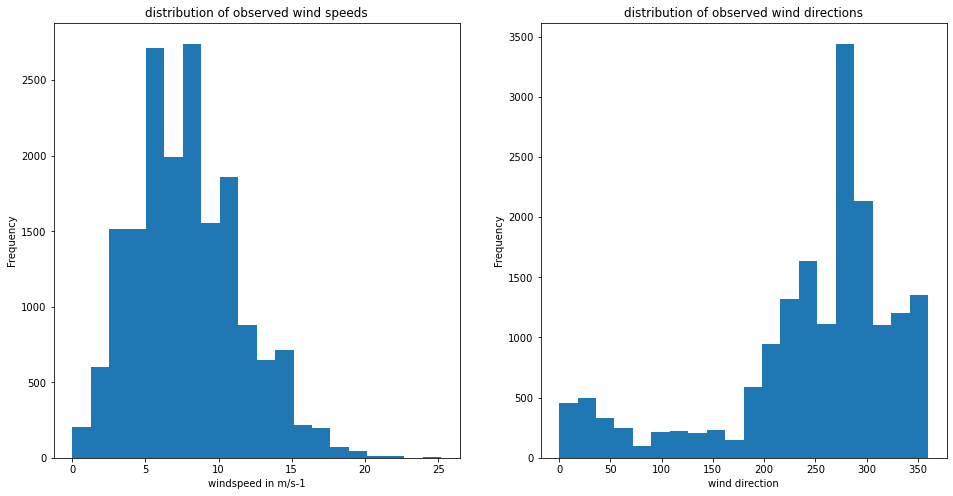

In [18]:
fig1 = matplotlib.pyplot.figure('distribution_wind_spevalue_countsirection', figsize=(16,8))
ax1 = fig1.add_subplot(1,2,1,title='distribution of observed wind speeds')
falklands_df['wind_speed_obs'].plot.hist(ax=ax1,bins=20)
ax1.set_xlabel('windspeed in m/s-1',)
ax1 = fig1.add_subplot(1,2,2,title='distribution of observed wind directions')
falklands_df['wind_direction_obs'].plot.hist(ax=ax1,bins=20)
ax1.set_xlabel('wind direction',)

Text(0.5, 0, 'dew point temperature (K)')

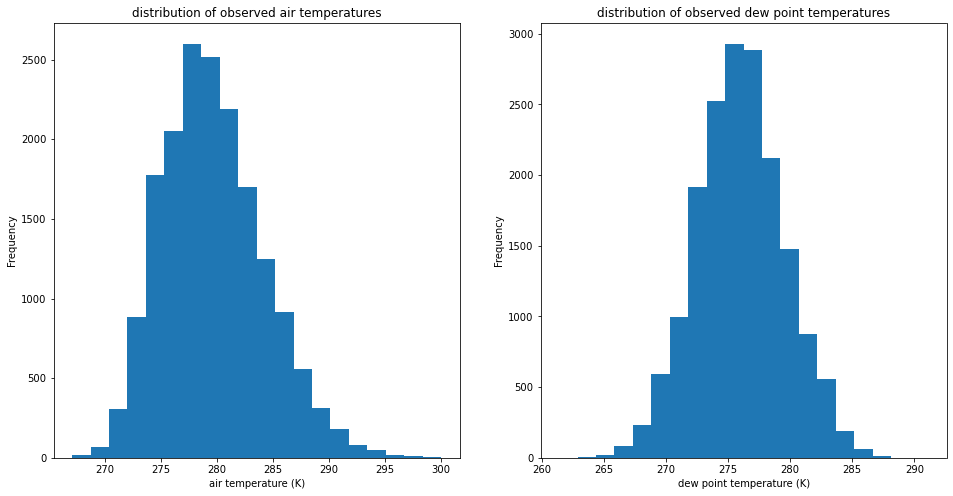

In [19]:
fig1 = matplotlib.pyplot.figure('distribution_temp_dewpoint', figsize=(16,8))
ax1 = fig1.add_subplot(1,2,1,title='distribution of observed air temperatures')
falklands_df['air_temp_obs'].plot.hist(ax=ax1,bins=20)
ax1.set_xlabel('air temperature (K)',)
ax1 = fig1.add_subplot(1,2,2,title='distribution of observed dew point temperatures')
falklands_df['dewpoint_obs'].plot.hist(ax=ax1,bins=20)
ax1.set_xlabel('dew point temperature (K)',)

Now compare for rotors present/absent

['air_temp_obs', 'dewpoint_obs', 'wind_direction_obs', 'wind_speed_obs']


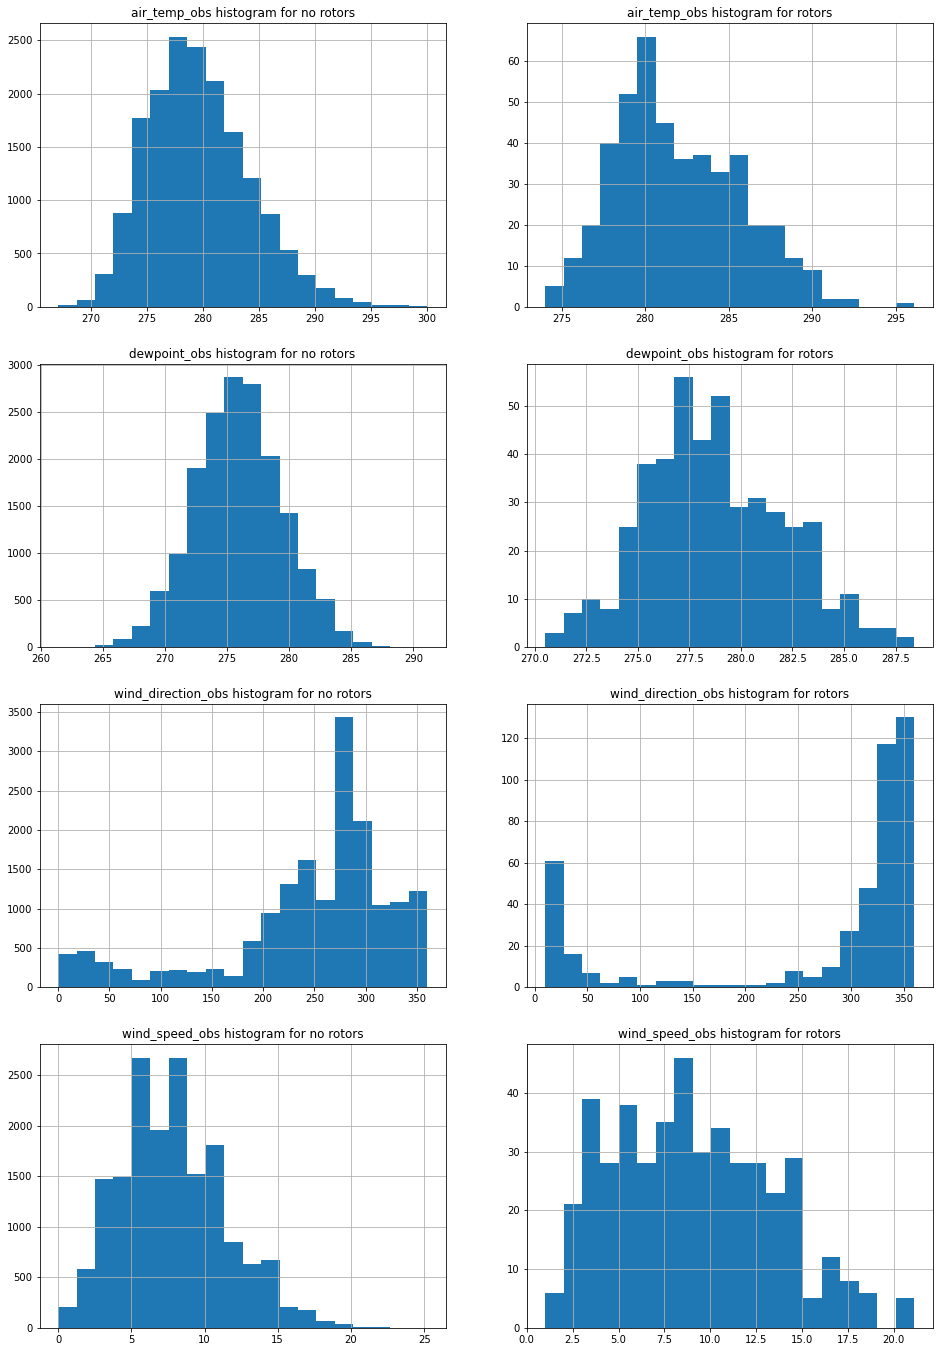

In [20]:
vars_to_plot = ['air_temp_obs', 'dewpoint_obs', 'wind_direction_obs', 'wind_speed_obs',]
print(vars_to_plot)
fig1 = matplotlib.pyplot.figure('comparing rota events',figsize=(16,6*len(vars_to_plot)))
for ix1, var_name in enumerate(vars_to_plot):
    ax1 = fig1.add_subplot(len(vars_to_plot),2,ix1*2+1, title=f'{var_name} histogram for no rotors')
    no_rotors_df[var_name].hist(bins=20,ax=ax1)
    ax1 = fig1.add_subplot(len(vars_to_plot),2,ix1*2+2, title=f'{var_name} histogram for rotors')
    rotors_present_df[var_name].hist(bins=20,ax=ax1)

The above diagrams already show some differences for conditions at the surface when a rotor is observed compared to when not. Most obvious is the wind direction, where rotors are found mostly in northerly winds, as is already known. Other surface variables show smaller differences.

We might also be interested in the link between occurences frequency at different times of day or in different seasons. The plots below show a small peak in the middle of the day (which may due to observation bias), but no other obviously exploitable patterns in the data.

Text(0.5, 0, 'hour of the day')

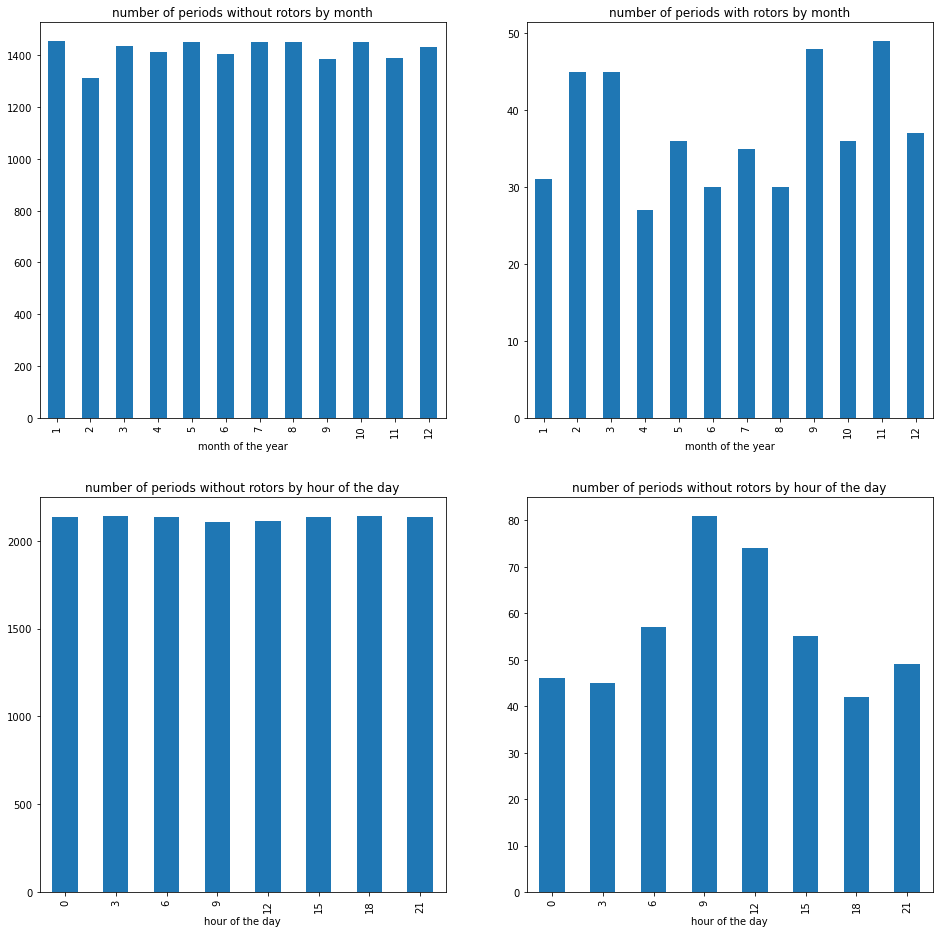

In [21]:
fig1 = matplotlib.pyplot.figure('time of year',figsize=(16,16))
ax1 = fig1.add_subplot(2,2,1, title='number of periods without rotors by month') 
no_rotors_df.groupby([ no_rotors_df['DTG'].apply(lambda x: x.month)])['DTG'].count().plot.bar( ax=ax1)
ax1.set_xlabel('month of the year')
ax1 = fig1.add_subplot(2,2,2, title='number of periods with rotors by month') 
rotors_present_df.groupby([ rotors_present_df['DTG'].apply(lambda x: x.month)])['DTG'].count().plot.bar(ax=ax1)
ax1.set_xlabel('month of the year')

ax1 = fig1.add_subplot(2,2,3, title='number of periods without rotors by hour of the day') 
no_rotors_df.groupby([ no_rotors_df['DTG'].apply(lambda x: x.hour)])['DTG'].count().plot.bar( ax=ax1)
ax1.set_xlabel('hour of the day')
ax1 = fig1.add_subplot(2,2,4, title='number of periods without rotors by hour of the day') 
rotors_present_df.groupby([ rotors_present_df['DTG'].apply(lambda x: x.hour)])['DTG'].count().plot.bar(ax=ax1)
ax1.set_xlabel('hour of the day')

In [22]:
features_dict = {
    'air_temp': [c1 for c1 in falklands_df.columns if 'air_temp' in c1 and 'obs' not in c1],
    'dewpoint': [c1 for c1 in falklands_df.columns if 'sh' in c1 and 'obs' not in c1],
    'wind_speed': [c1 for c1 in falklands_df.columns if 'windspd' in c1 and 'obs' not in c1],
    'wind_dir': [c1 for c1 in falklands_df.columns if 'winddir' in c1 and 'obs' not in c1],
}

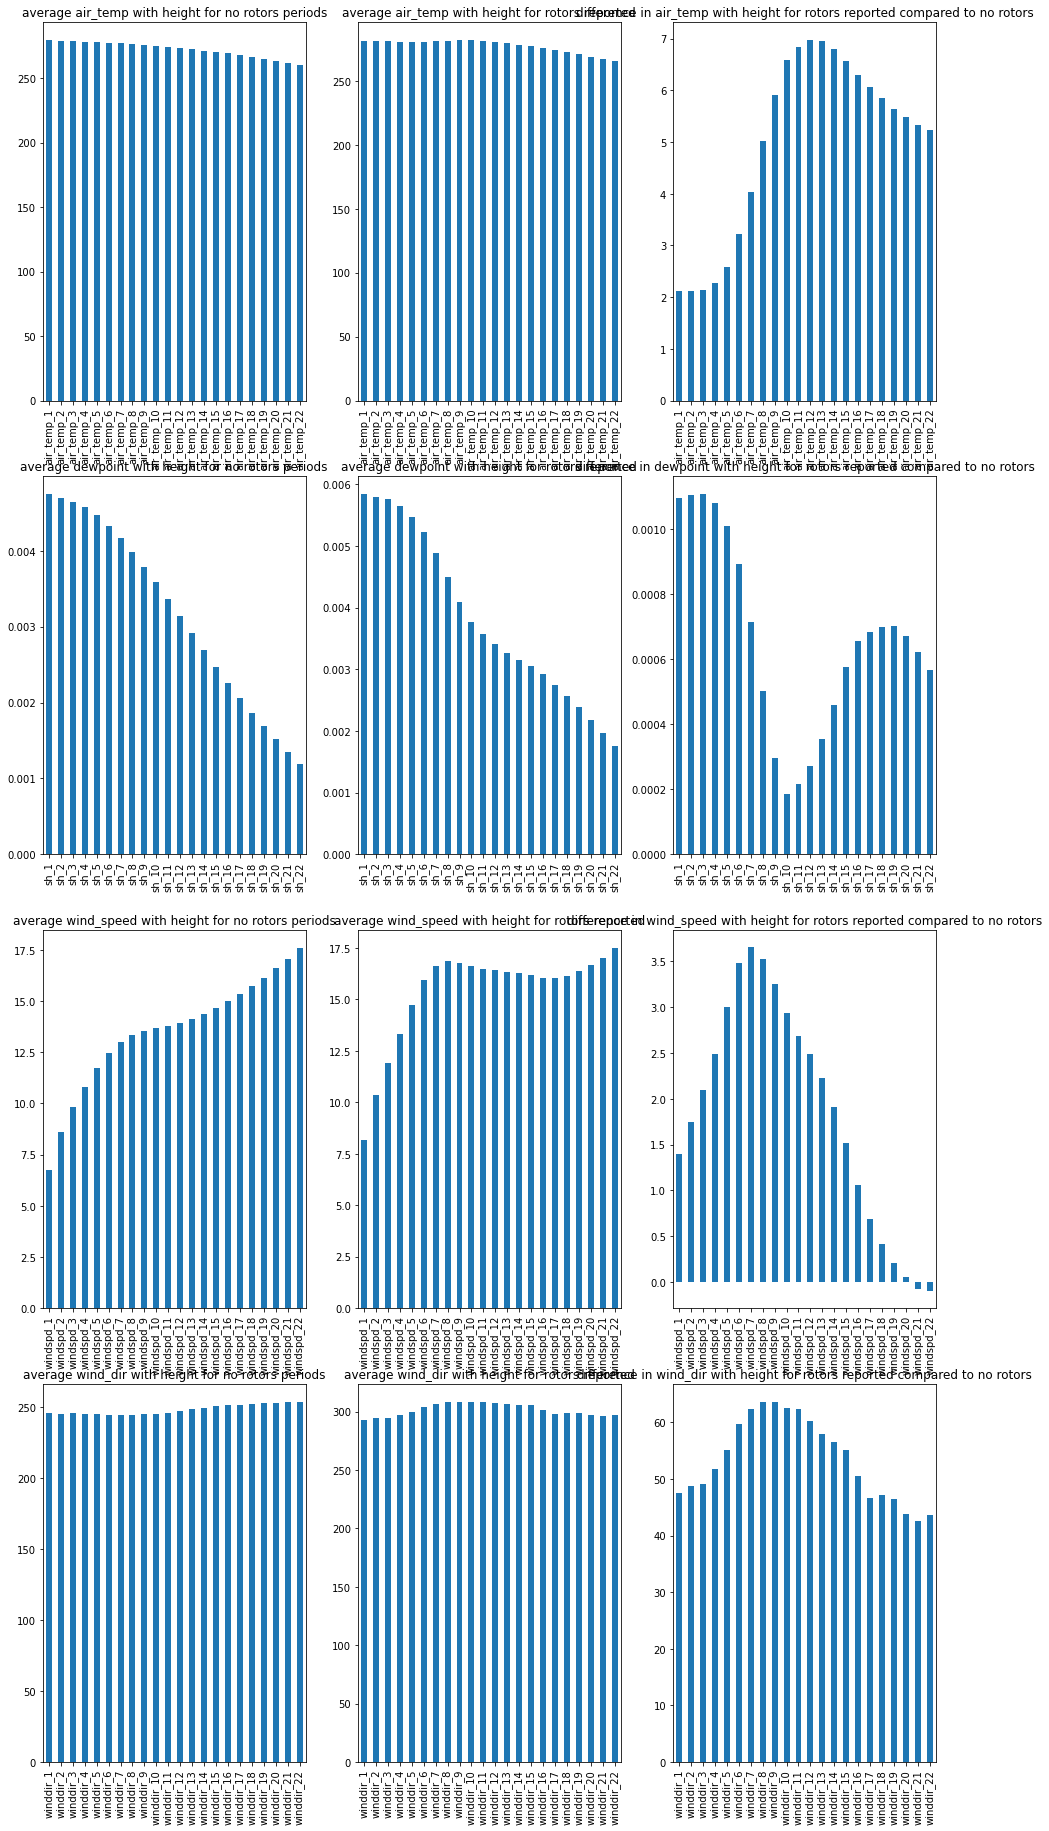

In [23]:
num_vars = len(features_dict.keys())
num_plots = 3
fig1 = matplotlib.pyplot.figure(figsize=(16,8*num_vars))
for ix1, (feature_name, fl1) in enumerate(features_dict.items()):
    ax1 = fig1.add_subplot(num_vars,num_plots,ix1*num_plots+1, title=f'average {feature_name} with height for no rotors periods')
    no_rotors_df[fl1].mean().plot.bar(ax=ax1)
    ax1 = fig1.add_subplot(num_vars,num_plots,ix1*num_plots+2, title=f'average {feature_name} with height for rotors reported')
    rotors_present_df[fl1].mean().plot.bar(ax=ax1)
    ax1 = fig1.add_subplot(num_vars,num_plots,ix1*num_plots+3, title=f'difference in {feature_name} with height for rotors reported compared to no rotors')
    (rotors_present_df[fl1].mean() - no_rotors_df[fl1].mean() ).plot.bar(ax=ax1)

Next up we want to explore the relationship between the forecast data and the observations.

### Comparison with human performance

This dataset also has some data contyaining the prediction made by human OpMets ahead of time. This is the baseline that we would need to match or improve upon for the algorithm to be useful.

In [24]:
opmet_results_path = falklands_data_dir / 'rotors_opmet_performance_2016_2021.csv'
opmet_results_path

PosixPath('/project/informatics_lab/data_science_cop/ML_challenges/2021_opmet_challenge/Rotors/rotors_opmet_performance_2016_2021.csv')

In [25]:
opmet_predictions_df = pandas.read_csv(opmet_results_path)

In [26]:
opmet_predictions_df.loc[opmet_predictions_df[opmet_predictions_df.observation.isna()].index,'observation'] = 0.0
opmet_predictions_df.loc[opmet_predictions_df[opmet_predictions_df['opmet_forecast'].isna()].index,'opmet_forecast'] = 0.0
opmet_predictions_df['DTG'] = pandas.to_datetime(opmet_predictions_df['DTG'])


In [27]:
opmet_predictions_df

,DTG,observation,opmet_forecast,Hit,False Positive,True Negative,Miss
0,2016-09-19 00:00:00,0.0,0.0,False,False,True,False
1,2016-09-19 01:00:00,0.0,0.0,False,False,True,False
2,2016-09-19 02:00:00,0.0,0.0,False,False,True,False
3,2016-09-19 03:00:00,0.0,0.0,False,False,True,False
4,2016-09-19 04:00:00,0.0,0.0,False,False,True,False
...,...,...,...,...,...,...,...
38971,2021-02-28 19:00:00,0.0,1.0,False,True,False,False
38972,2021-02-28 20:00:00,0.0,1.0,False,True,False,False
38973,2021-02-28 21:00:00,0.0,0.0,False,False,True,False
38974,2021-02-28 22:00:00,0.0,0.0,False,False,True,False


In [28]:
opmet_predictions_df['observation'].value_counts()

0.0    37726
1.0     1250
Name: observation, dtype: int64

In [29]:
opmet_predictions_df['opmet_forecast'].value_counts()

0.0     33551
1.0      5424
11.0        1
Name: opmet_forecast, dtype: int64

In [30]:
opmet_predictions_df['truePositive'] = ((opmet_predictions_df['observation'] == 1 ) & (opmet_predictions_df['opmet_forecast'] ==1))
opmet_predictions_df['falsePositive']  = ((opmet_predictions_df['observation'] == 0 ) & (opmet_predictions_df['opmet_forecast'] ==1))
opmet_predictions_df['trueNegative'] = ((opmet_predictions_df['observation'] == 0 ) & (opmet_predictions_df['opmet_forecast'] ==0))
opmet_predictions_df['falseNegative']  = ((opmet_predictions_df['observation'] == 1 ) & (opmet_predictions_df['opmet_forecast'] ==0))

In [31]:
opmet_predictions_df['result_category'] = 'trueNegative'
opmet_predictions_df.loc[opmet_predictions_df[opmet_predictions_df['falseNegative']==True].index,'result_category'] = 'falseNegative'
opmet_predictions_df.loc[opmet_predictions_df[opmet_predictions_df['falsePositive']==True].index,'result_category'] = 'falsePositive'
opmet_predictions_df.loc[opmet_predictions_df[opmet_predictions_df['truePositive']==True].index,'result_category'] = 'truePositive'

<AxesSubplot:title={'center':'true/false positive/negative proportions'}, ylabel='result_category'>

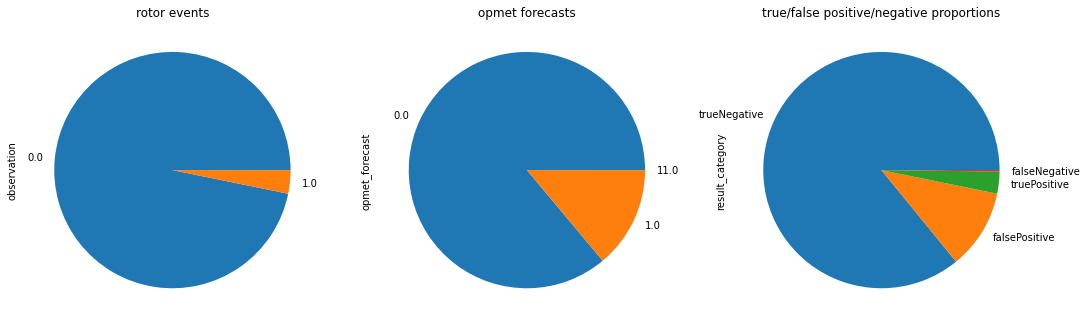

In [32]:
fig1 = matplotlib.pyplot.figure('comparisonn of hits/isses/etc.')
ax1 = fig1.add_subplot(1,3,1,title='rotor events')
opmet_predictions_df['observation'].value_counts().plot.pie(figsize=(18,6))
ax1 = fig1.add_subplot(1,3,2,title='opmet forecasts')
opmet_predictions_df['opmet_forecast'].value_counts().plot.pie(figsize=(18,6))
ax1 = fig1.add_subplot(1,3,3,title='true/false positive/negative proportions')
opmet_predictions_df['result_category'].value_counts().plot.pie(figsize=(18,6))

Exploration of this data shows us that OpMets routinely overpredict rotor events. This is what you would expect, as the cost of missing a rotor event (false negative) is much higher than the cost of predicting an event and it not happening (false positive). So the challenge for our ML algorithm is to eliminate false neagtives while maintaining an acceptably low false positive rate so as to maintain trust in forecast output.

## Load and explore gridded model data - ERA5

In [33]:
try:
    era5_root = os.environ['ERA5_DATA_ROOT']
except KeyError:
    era5_root = '/project/informatics_lab/data_science_cop/era5/'
era5_data_dir = pathlib.Path(era5_root) 
print(era5_data_dir)

/project/informatics_lab/data_science_cop/era5


In [36]:
nc_files = sorted([str(i1) for i1 in era5_data_dir.iterdir() if '.nc' in str(i1) and 'air_pressure' in str(i1)])
nc_files

['/project/informatics_lab/data_science_cop/era5/air_pressure_mean_sea_level_2017_01.nc',
 '/project/informatics_lab/data_science_cop/era5/air_pressure_mean_sea_level_2017_02.nc',
 '/project/informatics_lab/data_science_cop/era5/air_pressure_mean_sea_level_2017_03.nc',
 '/project/informatics_lab/data_science_cop/era5/air_pressure_mean_sea_level_2017_04.nc',
 '/project/informatics_lab/data_science_cop/era5/air_pressure_mean_sea_level_2017_05.nc',
 '/project/informatics_lab/data_science_cop/era5/air_pressure_mean_sea_level_2017_06.nc',
 '/project/informatics_lab/data_science_cop/era5/air_pressure_mean_sea_level_2017_07.nc',
 '/project/informatics_lab/data_science_cop/era5/air_pressure_mean_sea_level_2017_08.nc',
 '/project/informatics_lab/data_science_cop/era5/air_pressure_mean_sea_level_2017_09.nc']

In [38]:
era5_cubeList = iris.load(nc_files)
iris.util.equalise_attributes(era5_cubeList)
mslp_era5_cube = iris.cube.CubeList.concatenate_cube(era5_cubeList)

In [40]:
uk_na_bounds = {'latitude': (40,65), 'longitude': (-10,10)}

In [41]:
mslp_era5_uk_cube = mslp_era5_cube.intersection(latitude=uk_na_bounds['latitude'], 
                                                longitude=uk_na_bounds['longitude'])
mslp_era5_uk_cube

Air Pressure At Mean Sea Level (Pa),time,latitude,longitude
Shape,6552,101,81
Dimension coordinates,,,
time,x,-,-
latitude,-,x,-
longitude,-,-,x
Attributes,,,institution ECMWFleast_significant_digit 1nameCDM Mean_sea_level_pressure_surfacenameECMWF Mean sea level pressureproduct_type analysisshortNameECMWF mslsource Reanalysistilte ERA5 forecasts


In [42]:
iris.iris.coord_categorisation.add_season_number(mslp_era5_uk_cube,'time')

In [ ]:
functools.reduce(lambda x,y: x*y, mslp_2020_cube.shape), functools.reduce(lambda x,y: x*y, mslp_uk_2020_cube.shape)

In [ ]:
mslp_uk_2020_cube

In [45]:
min(mslp_era5_uk_cube.coord('latitude').points), max(mslp_era5_uk_cube.coord('latitude').points)

(40.0, 65.0)

In [46]:
min(mslp_era5_uk_cube.coord('longitude').points), max(mslp_era5_uk_cube.coord('longitude').points)

(-10.0, 10.0)

In [47]:
mslp_uk_seasonal_mean = mslp_era5_uk_cube.aggregated_by(['season_number'],iris.analysis.MEAN)
mslp_uk_seasonal_mean

<iris 'Cube' of air_pressure_at_mean_sea_level / (Pa) (time: 4; latitude: 101; longitude: 81)>

Now we can plot the seasonal averages as a way of exploring the data.
*NOTE* This cell will take a while to execute. This is because up until now none of the calculations described will actually have been executed, due to the *lazy loading* paradigm employed in Iris. Only at the point when the data is need (in our case to actually create the plots), are the compute operations actually triggered. So what is taking time is the subsetting and aggregation of the data, rather than only the actual plotting operations

In [ ]:
%%time
mslp_uk_seasonal_mean.data

In [ ]:
fig1 = matplotlib.pyplot.figure(figsize=(16,8))
for ix1 in range(mslp_uk_seasonal_mean.shape[0]):
    ax1 = fig1.add_subplot(1,4,ix1+1,projection=cartopy.crs.PlateCarree())
    iris.quickplot.contourf(mslp_uk_seasonal_mean[ix1],axes=ax1)
    ax1.coastlines()

## Next Steps

There are further example notebooks looking at loading and exploring data in python in the following locations:
* [Introduction to Data Analsyis in Python](https://github.com/informatics-lab/intro_python_data_analysis/)
* [Pangeo Lectures](https://github.com/informatics-lab/PangeoLectures)
* [Using Climate Data](https://github.com/Informatics-lab/UsingClimateData)


## Dataset Info

### Falklands Rotors Challenge Dataset
Crown Copyright 2021 - This dataset was created by Met Office Chief Operational Meterologist Steve Ramsdale from Met Office forecast and observation data.
* Model Data - Met Office Global 10km resolution model
* Observations - made by meteorologists at Mount Pleasant airfield in the Falkland Islands.

### ERA5
ERA5 is Renanlysis data created by ECMWF. Reanalysis combines observations from many sources. by assimilating these into a forecast model (ECMWF's IFS in this case), to provide a consistent physically valid gridded dataset that is a close to observations as possible
https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5



## References
* UNDER CONSTRUCTION*